# __Eksploracja danych__
## __Projekt 4: Asocjacyjne reguły grupowania__  
## __Karolina Węglowska, Krzysztof Stawarz__  

In [1]:
clc; clear; close all;
data = readmatrix('ed-p04.txt');
head(data)

     2     8    10    20    27    29    31    79    80    99   NaN   NaN
     5    19    30    43    44    64    70    73    79    87   NaN   NaN
     0     6    18    39    55    70    71    79    89    98   NaN   NaN
     1     2    29    32    33    51    56    72    85    95   NaN   NaN
    16    17    24    26    45    55    70    71    79   NaN   NaN   NaN
     6    14    20    25    33    40    51    54    72    88   NaN   NaN
     9    30    32    43    46    78    86    93    99   NaN   NaN   NaN
     4     5    41    55    56    60    78    79    81    88   NaN   NaN



In [2]:
numbers = rmmissing(unique(data));

transactions = zeros(size(data, 1), numel(numbers));
for x=1:size(data, 1)
    
    row = rmmissing(data(x, :));
    
    for y=1:size(row, 2)
        
        val = row(y);
        
        transactions(x, val+1) = transactions(x, val+1) + 1;
    end
    
end
 head(transactions(:, 1:11))

     0     0     1     0     0     0     0     0     1     0     1
     0     0     0     0     0     1     0     0     0     0     0
     1     0     0     0     0     0     1     0     0     0     0
     0     1     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     1     0     0     0     0
     0     0     0     0     0     0     0     0     0     1     0
     0     0     0     0     1     1     0     0     0     0     0




--------------ITERATION 1--------------
✅ Creating itemset : 0.01s
✅ Calculating support, creating frequentset : 0.00s

--------------ITERATION 2--------------
✅ Creating itemset : 0.10s
✅ Calculating support, creating frequentset : 0.05s

--------------ITERATION 3--------------
✅ Creating itemset : 0.12s
✅ Calculating support, creating frequentset : 0.98s

--------------ITERATION 4--------------
✅ Creating itemset : 0.18s
✅ Calculating support, creating frequentset : 3.19s

break3 - frequentset empty after calculating supports

Overal algorithm time (without pruning) for min_supp = 0.005 : 1.28s

valid_subsets =

     3    64    99
    13    51    62
    15    22    51
    16    39    98
    20    49    75
    22    51    76
    25    90    96
    32    45    51
    33    41    58
    45    71    82
    52    58    71
    59    63    73


valid_supports =

    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.0050
    0.00

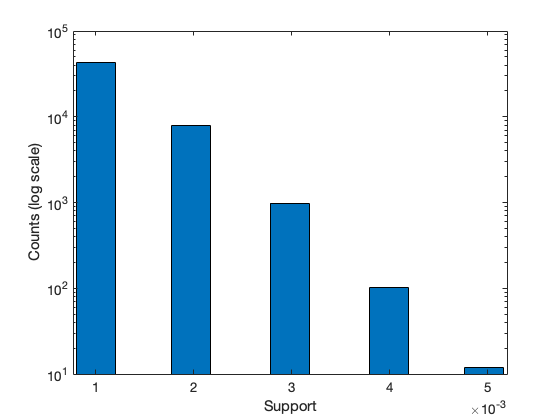

In [3]:
%  fajne thresholdy:
% min_supp = 0.0149;
min_supp = 0.005;
% min_supp = 0.003;
% min_supp = 0.002;

% min_supp = 2/5;

iteration = 0;

overall_time = 0;

while 1
    
    iteration = iteration + 1;
    disp(sprintf("\n--------------ITERATION %d--------------", iteration));
    
    %  creating new subsets
    tic
    if iteration==1
        c = rmmissing(unique(data));
    else
        tic
        possible_subsets=[];
        for i=1:size(data,1)

            row = rmmissing(data(i, :));

            sets = nchoosek(row, iteration);

            possible_subsets = [possible_subsets; sets];
        end

        c = unique(sort(possible_subsets, 2), 'rows');
        %c = nchoosek(unique(f), iteration);
    end
    
    time_creating_itemset = toc;
    disp(sprintf("✅ Creating itemset : %.2fs", time_creating_itemset));
    
    if isempty(c)
        disp(sprintf("\nbreak1 - new itemset empty after trying to create new with %d items"), iteration);
        valid_subsets = f;
        break;
    end
    
    
    % checking the supports and removing subsets below threshold
    tic;
    temp2 = [];
    for i=1:size(c, 1)
        c_row = c(i, :);
        support = sum(all(transactions(:,c_row+1), 2));
        temp2 = [temp2, support];
    end
    temp2 = temp2 / size(data, 1);
    temp1 = c(temp2>=min_supp, :);
    temp3 = temp2(temp2>=min_supp);



    
    time_calculating_support = toc;
    disp(sprintf("✅ Calculating support, creating frequentset : %.2fs", time_calculating_support));
    
    if isempty(temp1)

        valid_subsets = f;
        disp(sprintf("\nbreak3 - frequentset empty after calculating supports"));
        break;
    end
    
    f = temp1;
    supports = temp2;
    valid_supports = temp3';
    
    overall_time = overall_time + time_creating_itemset + time_calculating_support;
end

disp(sprintf("\nOveral algorithm time (without pruning) for min_supp = %.3f : %.2fs", min_supp, overall_time));

valid_subsets
valid_supports

% Create a histogram with logarithmic y-axis scale
edges = linspace(min(supports),max(supports));
counts = histcounts(supports,edges);
bar(edges(1:end-1),counts, 10);
set(gca,'YScale','log');
xlabel('Support');
ylabel('Counts (log scale)');
xticks(0:0.001:max(supports))

In [4]:
min_conf = 0.7;

confidences = [];

rule = 0;

for x=1:size(valid_subsets, 1)
    
    i = valid_subsets(x, :);
    k = size(i, 2);
    left_supp = valid_supports(x);

    
    while k > 1
        k_el_sets = nchoosek(i, k-1);
        
        for y=1:size(k_el_sets, 1)
            rule = rule + 1;
            
            s = k_el_sets(y, :);
            right_supp = sum(all(transactions(:,s+1), 2))/size(data,1);
            
            confidence = left_supp / right_supp;
            confidences = [confidences, confidence];

            if confidence >= min_conf
                i_minus_s = setdiff(i, s);
                
                disp(sprintf("\n------ Rule: %d ------", rule));
                disp("   " + num2str(s) + " ===> " + num2str(i_minus_s));
            end
            
        end
        
        k = k-1;
        
    end
    
end


------ Rule: 1 ------
   3  64 ===> 99

------ Rule: 19 ------
   16  39 ===> 98

------ Rule: 27 ------
   49  75 ===> 20

------ Rule: 45 ------
   45  51 ===> 32

------ Rule: 67 ------
   59  63 ===> 73


*Karolina Węglowska, Krzysztof Stawarz  
Kraków, 4.05.2023*